In [1]:
import numpy as np
import pylab as pl
from astropy.io import fits
from matplotlib import cm
cmap = cm.get_cmap('gray')
import time
import tensorflow as tf
import matplotlib.pyplot as plt
from skimage import exposure
%matplotlib inline
import pandas as pd
from scipy.ndimage import median_filter
from scipy.ndimage import median_filter



## data input

In [2]:
calib_data = 'data/ALICE_Machine-Learning/ALICE_RefCube_F110W_Era-2.fits'
calibdata = fits.open(calib_data)



In [3]:
ceti_49 = 'data/ALICE_Machine-Learning/ALICE_49-Ceti_F110W_Era-2.fits'
planet1 = fits.open(ceti_49)
hd_377 = 'data/ALICE_Machine-Learning/ALICE_HD-377_F110W_Era-2.fits'
planet2 = fits.open(hd_377)
hd_164249 = 'data/ALICE_Machine-Learning/ALICE_HD-164249_F110W_Era-2.fits'
planet3 = fits.open(hd_164249)
hd_181327 = 'data/ALICE_Machine-Learning/ALICE_HD-181327_F110W_Era-2.fits'
planet4 = fits.open(hd_181327)

In [4]:
def cut_image(img_data):
    cube = img_data[0].data
    Nframes = len(cube[:,0,0])
    Ny  = 64
    Nx  = 64

    # ylow = 325
    # xlow = 550

    ylow = 10
    xlow = 10

    cube_cut = np.zeros((Nframes,Nx,Ny))
    for i in range(Nframes):
        cube_cut[i,:,:] = cube[i,ylow:ylow+Ny,xlow:xlow+Nx]
    return cube_cut

In [5]:
raw_planet1 = cut_image(planet1)
raw_planet2 = cut_image(planet2)
raw_planet3 = cut_image(planet3)
raw_planet4 = cut_image(planet4)


In [6]:
##remove overly saturated pixels and replace with interpolated ones
def find_bright_pixels(data,tolerance=5,blur = 3):
    #This function finds the hot or dead pixels in a 2D dataset. 
    #tolerance is the number of standard deviations used to cutoff the hot pixels
    #If you want to ignore the edges and greatly speed up the code, then set
    #worry_about_edges to False.
    #
    #The function returns a list of hot pixels and also an image with with hot pixels removed    
    
    blurred = median_filter(data, size=blur)
    difference = data - blurred
    threshold = 10*np.std(difference)

    #find the hot pixels, but ignore the edges
    hot_pixels = np.nonzero((difference[1:-1,1:-1]>threshold) )
    hot_pixels = np.array(hot_pixels) + 1 #because we ignored the first row and first column
    fixed_image = np.copy(data) #This is the image with the hot pixels removed
    for y,x in zip(hot_pixels[0],hot_pixels[1]):
        fixed_image[y,x]=blurred[y,x]

    dead_pixels = np.nonzero(data<-1000)
    for y,x in zip(dead_pixels[0],dead_pixels[1]):
        fixed_image[y,x]=blurred[y,x]

    return fixed_image,blurred

In [7]:
# #inspect the cleaned image
# new_image,blurred = find_outlier_pixels(cube_cut[13])
# plt.imshow(new_image, cmap='gray')
# plt.colorbar()
# print('Mean:', np.min(new_image))

In [8]:
def remove_outliner(data_cube):
    new_data_cube = []
    for i in range(len(data_cube)):
        if np.max(data_cube[i]) > 10000:
            new_image,_ = find_bright_pixels(data_cube[i])
            new_data_cube.append(new_image)
        else:
            new_data_cube.append(data_cube[i])
    ## leave out images that are still overly saturated. 
    data_cube_with_cleaned = []
    for i in range(len(new_data_cube)):
        if np.max(new_data_cube[i]) > 10000:
            pass
        else:
            data_cube_with_cleaned.append(new_data_cube[i])
    return np.array(data_cube_with_cleaned)

In [9]:
def ignore_overly(data_cube):
    ### new data cube without images with overly-saturated points. 
    data_cube_without_saturation = []
    for i in range(len(data_cube)):
        if np.max(data_cube[i]) > 10000:
            pass
        else:
            data_cube_without_saturation.append(data_cube[i])
    return data_cube_without_saturation

## data normalisation method

In [10]:
def local_normal(data):
    new_imgs_list = []
    for imgs in data:
        local_min = np.min(imgs)
        new_imgs = imgs - local_min
        local_max = np.max(new_imgs)
        new_imgs = new_imgs/local_max
        new_imgs_list.append(new_imgs)
    return np.array(new_imgs_list).reshape(-1,64,64)

In [11]:
raw_data = cut_image(calibdata)
cleaned_data = ignore_overly(raw_data)


In [13]:
np.shape(cleaned_data)

(742, 64, 64)

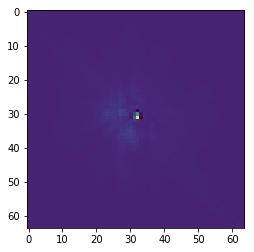

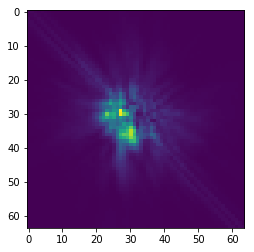

In [17]:
plt.imshow(raw_data[1])
plt.show()
plt.imshow(cleaned_data[7])
plt.show()

In [15]:

global_min_bfe = np.min(data_cube_with_cleaned)
lifted_cube = data_cube_with_cleaned+ abs(global_min_bfe)+1
global_min_aft = np.min(lifted_cube)
global_max = np.max(lifted_cube)
min_distance = np.zeros((len(lifted_cube)))
max_distance = np.zeros((len(lifted_cube)))

for i in range(len(lifted_cube)):
    local_max = np.max(lifted_cube[i])
    local_min = np.min(lifted_cube[i])
    min_distance[i] += (abs(global_min_aft)+abs(local_min))
    max_distance[i] += global_max-local_max

nor_min_dis = min_distance/np.max(min_distance)
nor_max_dis = 1- max_distance/np.max(max_distance)

In [16]:
print("lift_up_factor",abs(global_min_bfe)+1)
print("min_distance",np.max(min_distance))
print("max_distance",np.max(max_distance))

normal_info = np.array([abs(global_min_bfe)+1,np.max(min_distance),np.max(max_distance),global_min_aft,global_max])

lift_up_factor 1000.85418701
min_distance 1012.42256451
max_distance 9056.13032603


In [27]:
def scale_data(data_cube,lift_up_factor,global_max,global_min,max_min_dis,max_max_dis):
    data_cube1 = data_cube+ abs(lift_up_factor)
    print(np.min(data_cube))
    print(np.min(data_cube1))
    if np.min(data_cube1)<0:
        print("outside bound")
    else:
        data_nor = local_normal(data_cube1)
        nor_data_hybrid = np.zeros_like(data_nor)
        
        for i in range(len(data_nor)):
            local_max = np.max(data_cube1[i])
            local_min = np.min(data_cube1[i])
            min_distance = (abs(global_min)+abs(local_min))
            max_distance = global_max-local_max
            nor_min_dis = min_distance/max_min_dis
            nor_max_dis = 1- max_distance/max_max_dis
            test_img = data_nor[i].copy()
            test_img[:3,:] = nor_max_dis
            test_img[61:,:] = nor_min_dis
            nor_data_hybrid[i,:,:] += test_img
    return nor_data_hybrid

In [17]:

#train test split
from sklearn.model_selection import train_test_split
X = lifted_cube
X_train, X_test = train_test_split(X, test_size=0.10, random_state=42)




In [36]:
nor_test = scale_data(X_test,0,global_max,global_min_aft,np.max(min_distance),np.max(max_distance))

14.0353393555
14.0353393555


In [ ]:
### same treatment to test data.
clean_planet1 = remove_outliner(raw_planet1)
clean_planet2 = remove_outliner(raw_planet2)
clean_planet3 = remove_outliner(raw_planet3)
clean_planet4 = remove_outliner(raw_planet4)

#normalisation using given dynamic range.


In [ ]:
clean_planet1.min()

In [ ]:
planet2_normal = scale_data(clean_planet2,abs(global_min_bfe)+1,global_max,global_min_aft,np.max(min_distance),np.max(max_distance))
planet4_normal = scale_data(clean_planet4,abs(global_min_bfe)+1,global_max,global_min_aft,np.max(min_distance),np.max(max_distance))
planet3_normal = scale_data(clean_planet3,abs(global_min_bfe)+1,global_max,global_min_aft,np.max(min_distance),np.max(max_distance))

In [ ]:
i=3
plt.imshow(clean_planet3[i])
plt.colorbar()
plt.show()
plt.imshow(planet3_normal[i])
plt.colorbar()
plt.show()
print(np.max(raw_planet3[i]),np.max(clean_planet3[i]))
print(np.min(raw_planet3[i]),np.min(clean_planet3[i]))

print(raw_planet3[i][np.where(raw_planet3[i]<0)])

np.save("HST_hd377_hybrid",planet2_normal)
np.save("HST_hd_164249_hybrid",planet3_normal)
np.save("HST_hd_181327_hybrid",planet4_normal)

### 

## Data augmentation


In [12]:
import imgaug as ia 
from imgaug import augmenters as iaa

In [ ]:
np.shape(X_train),np.shape(X_test)

In [13]:
def add_salt_pepper_noise(X_imgs,sp_ratio=0.5,number=0.0006):
    # Need to produce a copy as to not modify the original image
    X_imgs_copy = X_imgs.copy()
    row, col = X_imgs_copy.shape
    salt_vs_pepper = sp_ratio
    amount = number
    num_salt = np.ceil(amount * X_imgs_copy.size * salt_vs_pepper)
    num_pepper = np.ceil(amount * X_imgs_copy.size * (1.0 - salt_vs_pepper))

        # Add Salt noise
    coords = [np.random.randint(0, i - 1, int(num_salt)) for i in X_imgs_copy.shape]
    X_imgs_copy[coords[0], coords[1]] = 1
        # Add Pepper noise
    coords = [np.random.randint(0, i - 1, int(num_pepper)) for i in X_imgs_copy.shape]
    X_imgs_copy[coords[0], coords[1]] = 0
    return X_imgs_copy

In [14]:
def add_gaussian_noise(X_imgs,mean = 0,sigma = 0.1):
    row, col= X_imgs.shape
    gauss = np.random.normal(mean,sigma,(row,col))    
    new_img = X_imgs + gauss

    return new_img
  


In [ ]:
X_train = np.array(X_train)
X_test = np.array(X_test)

In [19]:
##Data augmenation pipeline. 

def data_aug(data,check_img = False):
    ##adding gaussian noise
    length = len(data)
    noise_list = np.arange(0,12,2)
    randn_list = np.random.randint(len(noise_list),size=length)
    noise_imgs = []
    
    for idx,imgs in enumerate(data):
        gaus_imgs = add_gaussian_noise(imgs,noise_list[randn_list[idx]],sigma=0.5)
        if (check_img == True and idx == 300):
            plt.imshow(gaus_imgs)
            plt.show()
        noise_imgs.append(gaus_imgs)
    noise_imgs = np.array(noise_imgs).reshape(-1,64,64)
    #extract global min max
    global_min_aft = np.min(data)
    global_max = np.max(data)
    min_distance = np.zeros((len(data)))
    max_distance = np.zeros((len(data)))
    ##normalisation
    nor_train = local_normal(noise_imgs)
    print(np.max(nor_train))
    for i in range(len(data)):
        local_max = np.max(data[i])
        local_min = np.min(data[i])
        min_distance[i] += (abs(global_min_aft)+abs(local_min))
        max_distance[i] += global_max-local_max

    nor_min_dis = min_distance/np.max(min_distance)
    nor_max_dis = 1- max_distance/np.max(max_distance)
    
    ##add salt and pepper
    augmented_imgs = []
    sp_ratio_list = np.arange(0.1, 0.8,0.1)
    freq = np.arange(0.01,0.04,0.005)
    scale_list = np.arange(0.8,1.4, 0.05)
    rotate_list = np.arange(-90,0,90)
    randn_list2 = np.random.randint(len(sp_ratio_list),size=length)
    randn_list3 = np.random.randint(len(freq),size=length)
    randn_list4 = np.random.randint(len(scale_list),size=length)
    randn_list5 = np.random.randint(2,size = length)
    randn_list6 = np.random.randint(2,size = length)
    randn_list7 = np.random.randint(len(rotate_list),size=length)
    for idx,imgs in enumerate(nor_train):
        enlarger = iaa.Affine(scale=scale_list[randn_list4[idx]])
        scaled_imgs = enlarger.augment_image(imgs)
        if (check_img == True and idx == 300):
            plt.imshow(scaled_imgs)
            plt.show()
        seasoned = add_salt_pepper_noise(scaled_imgs,sp_ratio=sp_ratio_list[randn_list2[idx]],number=freq[randn_list3[idx]])
        if (check_img == True and idx == 300):
            plt.imshow(seasoned)
            plt.show()
        fliperlr = iaa.Fliplr(randn_list5[idx])
        fliperud = iaa.Flipud(randn_list6[idx])
        flip_imgs = fliperlr.augment_image(seasoned)
        flip_imgs = fliperud.augment_image(flip_imgs)
        if (check_img == True and idx == 300):
            plt.imshow(flip_imgs)
            plt.show()
        rotator = iaa.Affine(rotate=rotate_list[randn_list7[idx]])
        rotate_imgs = rotator.augment_image(flip_imgs)
        if (check_img == True and idx == 300):
            plt.imshow(rotate_imgs)
            plt.show()
        
        augmented_imgs.append(rotate_imgs)
    augmented_imgs=np.array(augmented_imgs).reshape(-1,64,64)
    
    #ADD NOR FACTOR
    nor_data_hybrid = np.zeros_like(augmented_imgs)
    for i in range(len(augmented_imgs)):
        test_img = augmented_imgs[i].copy()
        test_img[:3,:] = nor_max_dis[i]
        test_img[61:,:] = nor_min_dis[i]
        nor_data_hybrid[i,:,:] += test_img
    np.max(nor_data_hybrid)
    return nor_data_hybrid
        
    
        
        

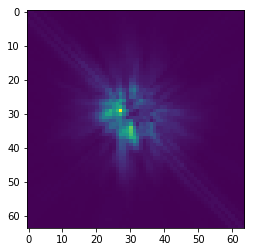

1.0


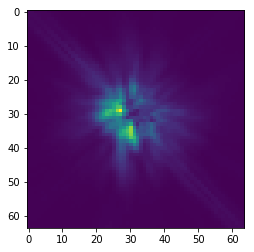

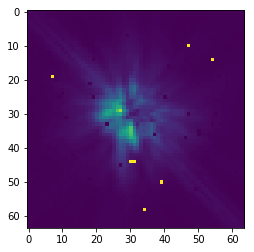

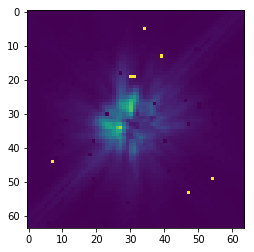

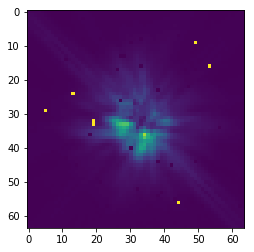

In [20]:
#test 
aug_images = data_aug(X_train,check_img=True)

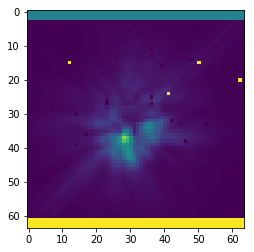

In [26]:
plt.imshow(aug_images[33])

In [33]:
aug_images.shape
aug_data_cube = []
for i in range(8):
    aug_images = data_aug(X_train)
    aug_data_cube.append(aug_images)
aug_data_cube = np.array(aug_data_cube).reshape(-1,64,64)

1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0


In [34]:
aug_data_cube.shape

(5776, 64, 64)

# Interpolation to create new images

In [ ]:
np.shape(training)

weight = np.arange(0.1,1,0.1)

print(weight)
new_img_list = np.array([])
for i in range(1):
    test_img = training[i]
    for j in range(5):
        if i != j:
            test_img2 = training[j]
            new_img = np.zeros_like(test_img)
            randint = np.random.randint(len(weight))
            for k in range(len(test_img)):
                new_img[k] += (weight[randint]*test_img[k] +(1-weight[randint])*test_img2[k])/1
            new_img_list = np.append(new_img_list,new_img)    

new_img_list = new_img_list.reshape(-1,64,64)
new_img_list.shape
for i in range(len(new_img_list)):
    print(np.max(new_img_list[i]),np.min(new_img_list[i]),np.mean(new_img_list[i]))

## stacking cube and normalisation

In [37]:
nor_train = scale_data(X_train,0,global_max,global_min_aft,np.max(min_distance),np.max(max_distance))
train_image = np.vstack([nor_train,aug_data_cube])
train_image.shape

1.0
1.0


(6498, 64, 64)

In [38]:
np.save('HST_aug_hybrid_5776', train_image)
# np.save('HST_aug_data_test', nor_test)

## check the residual between calib. stars

In [ ]:
normalised_training_set = normalise_cube(data_cube_without_saturation)

In [ ]:
mean_img = np.mean(normalised_training_set,axis=0)

In [ ]:
residual_block = normalised_training_set - mean_img